# **Importing Libraries**

In [ ]:
#Set path to MAIN FOLDER OF EXPERIMENT
#cd /path/to/EXPERIMENT_FOLDER/

/content/drive/My Drive/PSR


In [4]:
#Import Evaluation metrics modules
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc

#Import custom modules
from utils.plot_utils import plot_acc, plot_loss, plot_confusion, plot_pr, plot_roc, plot_bubble
from utils.eval_utils import cal_macro_roc, cal_macro_pr, cal_param_flops
from utils.eval_utils import get_generator, get_prediction
from utils.load_utils import init_models
import utils.plot_utils as plot

#Other modules
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
import numpy as np
import pickle
import math
import os

In [5]:
#Define Constants
IMAGE_SIZE = (256,256)
TOTAL_CLASSES = 199
BATCH_SIZE = 4
TEXT_MODE = True
FONT_SIZE = 7.5
DPI=600

#Data paths
VAL_DATA_PATH = 'ds/val/'
TEST_DATA_PATH = 'ds/test/'

#Model paths
DIST_STUDENT_MODEL_PATH = 'models/Distilled_Student_Models/'
NORMAL_STUDENT_MODEL_PATH = 'models/Student_Models/'
TEACHER_MODEL_PATH = 'models/Teacher_Models/'

#Figures paths
DIST_STUDENT_FIG_PATH = 'figures/Distilled_Student_Figures/'
NORMAL_STUDENT_FIG_PATH = 'figures/Student_Figures/'
TEACHER_FIG_PATH = 'figures/Teacher_Figures/'

# **Evaluation Of Teacher Models**

**Initialize Models and Evalutaion Parameters**

In [6]:
#Initialize models
MODEL_FILES = ['DenseNet201', 'Xception', 'InceptionResNetV2', 'ResNet152V2', 'EfficientNetB7', 'NASNetLarge', 'EnsembleModel']
models = init_models(MODEL_FILES)

#Initialize Evaluation Parameters
MEASURES = ['Accuracy(%)', 'MSLE', 'Precision(%)', 'Recall(%)', 'F1-score(%)', 'PR-AUC', 'ROC-AUC']
val_results = {}
test_results = {}
for m in MEASURES:
    val_results[m] = {}
    test_results[m] = {}

#Initialize predictions
val_preds = {}
test_preds = {}
for file in MODEL_FILES:
    val_preds[file] = {'y_true':None, 'y_prob':None, 'y_soft_prob':None ,'y_pred':None}
    test_preds[file] = {'y_true':None, 'y_prob':None, 'y_soft_prob':None ,'y_pred':None}

[INFO] Loading Model: DenseNet201
[INFO] Loading Model: Xception
[INFO] Loading Model: InceptionResNetV2
[INFO] Loading Model: ResNet152V2
[INFO] Loading Model: EfficientNetB7
[INFO] Loading Model: NASNetLarge
[INFO] Loading Model: EnsembleModel


**Get Predictions**

In [7]:
for file in MODEL_FILES:
    model = models[file]['model']
    #Get Generators and no. of samples in Validation and Test Set
    validation_generator, nb_validation_samples = get_generator(VAL_DATA_PATH, 'sparse', models[file]['preprocess_func'], rescale=models[file]['rescale'])
    test_generator, nb_test_samples = get_generator(TEST_DATA_PATH, 'sparse', models[file]['preprocess_func'], rescale=models[file]['rescale'])

    print('\n[INFO] Getting Predictions for ' + file + ' on Validation and Test Set')
    #Get Validation Predictions
    y_true, y_prob, y_soft_prob, y_pred = get_prediction(model, validation_generator, nb_validation_samples)
    val_preds[file]['y_true'] = y_true
    val_preds[file]['y_prob'] = y_prob
    val_preds[file]['y_soft_prob'] = y_soft_prob
    val_preds[file]['y_pred'] = y_pred

    #Get Test Predictions
    y_true, y_prob, y_soft_prob, y_pred = get_prediction(model, test_generator, nb_test_samples)
    test_preds[file]['y_true'] = y_true
    test_preds[file]['y_prob'] = y_prob
    test_preds[file]['y_soft_prob'] = y_soft_prob
    test_preds[file]['y_pred'] = y_pred

Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.

[INFO] Getting Predictions for DenseNet201 on Validation and Test Set



Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.

[INFO] Getting Predictions for Xception on Validation and Test Set



Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.

[INFO] Getting Predictions for InceptionResNetV2 on Validation and Test Set



Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.

[INFO] Getting Predictions for ResNet152V2 on Validation and Test Set



Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.

[INFO] Getting Predictions for EfficientNetB7 on Validation and Test Set



Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.

[INFO] Getting Predictions for NASNetLarge on Validation and Test Set



Found 1194 images belonging to 199 classes.
Found 796 images belonging to 199 classes.

[INFO] Getting Predictions for EnsembleModel on Validation and Test Set


**Evaluation on Validation set**

In [8]:
for model_name in MODEL_FILES:
    print('[INFO] Evaluating ' + model_name + ' on Validation Set')
    y_true, y_pred, y_prob, y_soft_prob = (val_preds[model_name]['y_true'], val_preds[model_name]['y_pred'], 
                                           val_preds[model_name]['y_prob'], val_preds[model_name]['y_soft_prob'])

    #Update Accuracy, MSE and MSLE
    val_results['Accuracy(%)'][model_name] = '{0:.4f}'.format(accuracy_score(y_true, y_pred)*100)
    val_results['MSLE'][model_name] = '{0:.4f}'.format(mean_squared_log_error(y_true, y_pred))

    #Update Precision, Recall and Fscore - Macro
    avg_pre, avg_rec, avg_fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    val_results['Precision(%)'][model_name] = '{0:.4f}'.format(avg_pre*100)
    val_results['Recall(%)'][model_name] = '{0:.4f}'.format(avg_rec*100)
    val_results['F1-score(%)'][model_name] = '{0:.4f}'.format(avg_fscore*100)

    #Update ROC-AUC PR-AUC - Macro
    y_true = to_categorical(y_true)
    macro_fpr, macro_tpr = cal_macro_roc(y_true, y_soft_prob, TOTAL_CLASSES)
    macro_rec, macro_pre = cal_macro_pr(y_true, y_soft_prob, TOTAL_CLASSES)
    ROC_AUC = auc(macro_fpr, macro_tpr)
    PR_AUC = auc(macro_rec, macro_pre)
    val_results['ROC-AUC'][model_name] = '{0:.4f}'.format(ROC_AUC)
    val_results['PR-AUC'][model_name] = '{0:.4f}'.format(PR_AUC)

[INFO] Evaluating DenseNet201 on Validation Set
[INFO] Evaluating Xception on Validation Set
[INFO] Evaluating InceptionResNetV2 on Validation Set
[INFO] Evaluating ResNet152V2 on Validation Set
[INFO] Evaluating EfficientNetB7 on Validation Set
[INFO] Evaluating NASNetLarge on Validation Set
[INFO] Evaluating EnsembleModel on Validation Set


In [9]:
#See results
print("\t\t\tEVALUATION RESULTS OF TEACHER MODELS ON VALIDATION SET")
print("\t\t\t-------------------------------------------------------")
df_val = pd.DataFrame(val_results)
df_val

			EVALUATION RESULTS OF TEACHER MODELS ON VALIDATION SET
			-------------------------------------------------------


,Accuracy(%),MSLE,Precision(%),Recall(%),F1-score(%),PR-AUC,ROC-AUC
DenseNet201,90.9548,0.1025,92.9360,90.9548,90.6326,0.8948,0.9994
Xception,86.2647,0.2356,89.0092,86.2647,85.9274,0.8734,0.9988
InceptionResNetV2,86.5997,0.2107,89.5055,86.5997,85.9133,0.8800,0.9979
ResNet152V2,84.0034,0.2291,87.3226,84.0034,83.7818,0.8544,0.9973
EfficientNetB7,92.2948,0.1553,94.0689,92.2948,92.1262,0.9102,0.9998
NASNetLarge,86.7672,0.1506,89.3156,86.7672,86.3704,0.8784,0.9983
EnsembleModel,93.4673,0.1128,94.9797,93.4673,93.2125,0.9088,0.9998


**Evaluation on Testing Set**

In [10]:
for model_name in MODEL_FILES:
    print('[INFO] Evaluating ' + model_name + ' on Test Set')
    y_true, y_pred, y_prob, y_soft_prob = (test_preds[model_name]['y_true'], test_preds[model_name]['y_pred'], 
                                           test_preds[model_name]['y_prob'], test_preds[model_name]['y_soft_prob'])

    #Update Accuracy and MSLE
    test_results['Accuracy(%)'][model_name] = '{0:.4f}'.format(accuracy_score(y_true, y_pred)*100)
    test_results['MSLE'][model_name] = '{0:.4f}'.format(mean_squared_log_error(y_true, y_pred))

    #Update Macro Precision, Macro Recall and Macro Fscore 
    avg_pre, avg_rec, avg_fscore, _ = precision_recall_fscore_support(y_true, y_pred, average='macro', zero_division=0)
    test_results['Precision(%)'][model_name] = '{0:.4f}'.format(avg_pre*100)
    test_results['Recall(%)'][model_name] = '{0:.4f}'.format(avg_rec*100)
    test_results['F1-score(%)'][model_name] = '{0:.4f}'.format(avg_fscore*100)

    #Update Macro ROC-AUC Macro PR-AUC
    y_true = to_categorical(y_true)
    macro_fpr, macro_tpr = cal_macro_roc(y_true, y_soft_prob, TOTAL_CLASSES)
    macro_rec, macro_pre = cal_macro_pr(y_true, y_soft_prob, TOTAL_CLASSES)
    ROC_AUC = auc(macro_fpr, macro_tpr)
    PR_AUC = auc(macro_rec, macro_pre)
    test_results['ROC-AUC'][model_name] = '{0:.4f}'.format(ROC_AUC)
    test_results['PR-AUC'][model_name] = '{0:.4f}'.format(PR_AUC)

[INFO] Evaluating DenseNet201 on Test Set
[INFO] Evaluating Xception on Test Set
[INFO] Evaluating InceptionResNetV2 on Test Set
[INFO] Evaluating ResNet152V2 on Test Set
[INFO] Evaluating EfficientNetB7 on Test Set
[INFO] Evaluating NASNetLarge on Test Set
[INFO] Evaluating EnsembleModel on Test Set


In [11]:
#See results
print("\t\t\tEVALUATION RESULTS OF TEACHER MODELS ON TEST SET")
print("\t\t\t-------------------------------------------------")
df_test = pd.DataFrame(test_results)
df_test

			EVALUATION RESULTS OF TEACHER MODELS ON TEST SET
			-------------------------------------------------


,Accuracy(%),MSLE,Precision(%),Recall(%),F1-score(%),PR-AUC,ROC-AUC
DenseNet201,89.5729,0.1062,92.5489,89.5729,88.9640,0.8774,0.9997
Xception,84.1709,0.1896,86.9008,84.1709,83.0912,0.8543,0.9987
InceptionResNetV2,86.5578,0.1644,88.2348,86.5578,85.4701,0.8562,0.9979
ResNet152V2,82.5377,0.2082,86.0509,82.5377,81.2675,0.8408,0.9985
EfficientNetB7,92.0854,0.0759,94.0727,92.0854,91.8036,0.8867,0.9998
NASNetLarge,86.9347,0.1560,90.7061,86.9347,86.5689,0.8704,0.9992
EnsembleModel,92.4623,0.0548,93.3186,92.4623,91.8215,0.8877,0.9999


# **Plotting Curves**

In [13]:
#Set plot initials
plot.MODELS_PATH = TEACHER_MODEL_PATH
plot.SAVE_PATH = TEACHER_FIG_PATH
plot.TOTAL_CLASSES = TOTAL_CLASSES
plot.TEXT_MODE = TEXT_MODE
plot.FONT_SIZE = FONT_SIZE
plot.DPI = DPI

#Set results and preds
plot.test_results = test_results
plot.val_results = val_results
plot.test_preds = test_preds
plot.val_preds = val_preds
plot.models = models

plot.update_env()
print("[INFO] PLOT ENVIRONMENT VARIABLES UPDATED")

[INFO] PLOT ENVIRONMENT VARIABLES UPDATED


**Plot Accuracy Curves**

[INFO] ACCURACY CURVES FOR TEACHERS


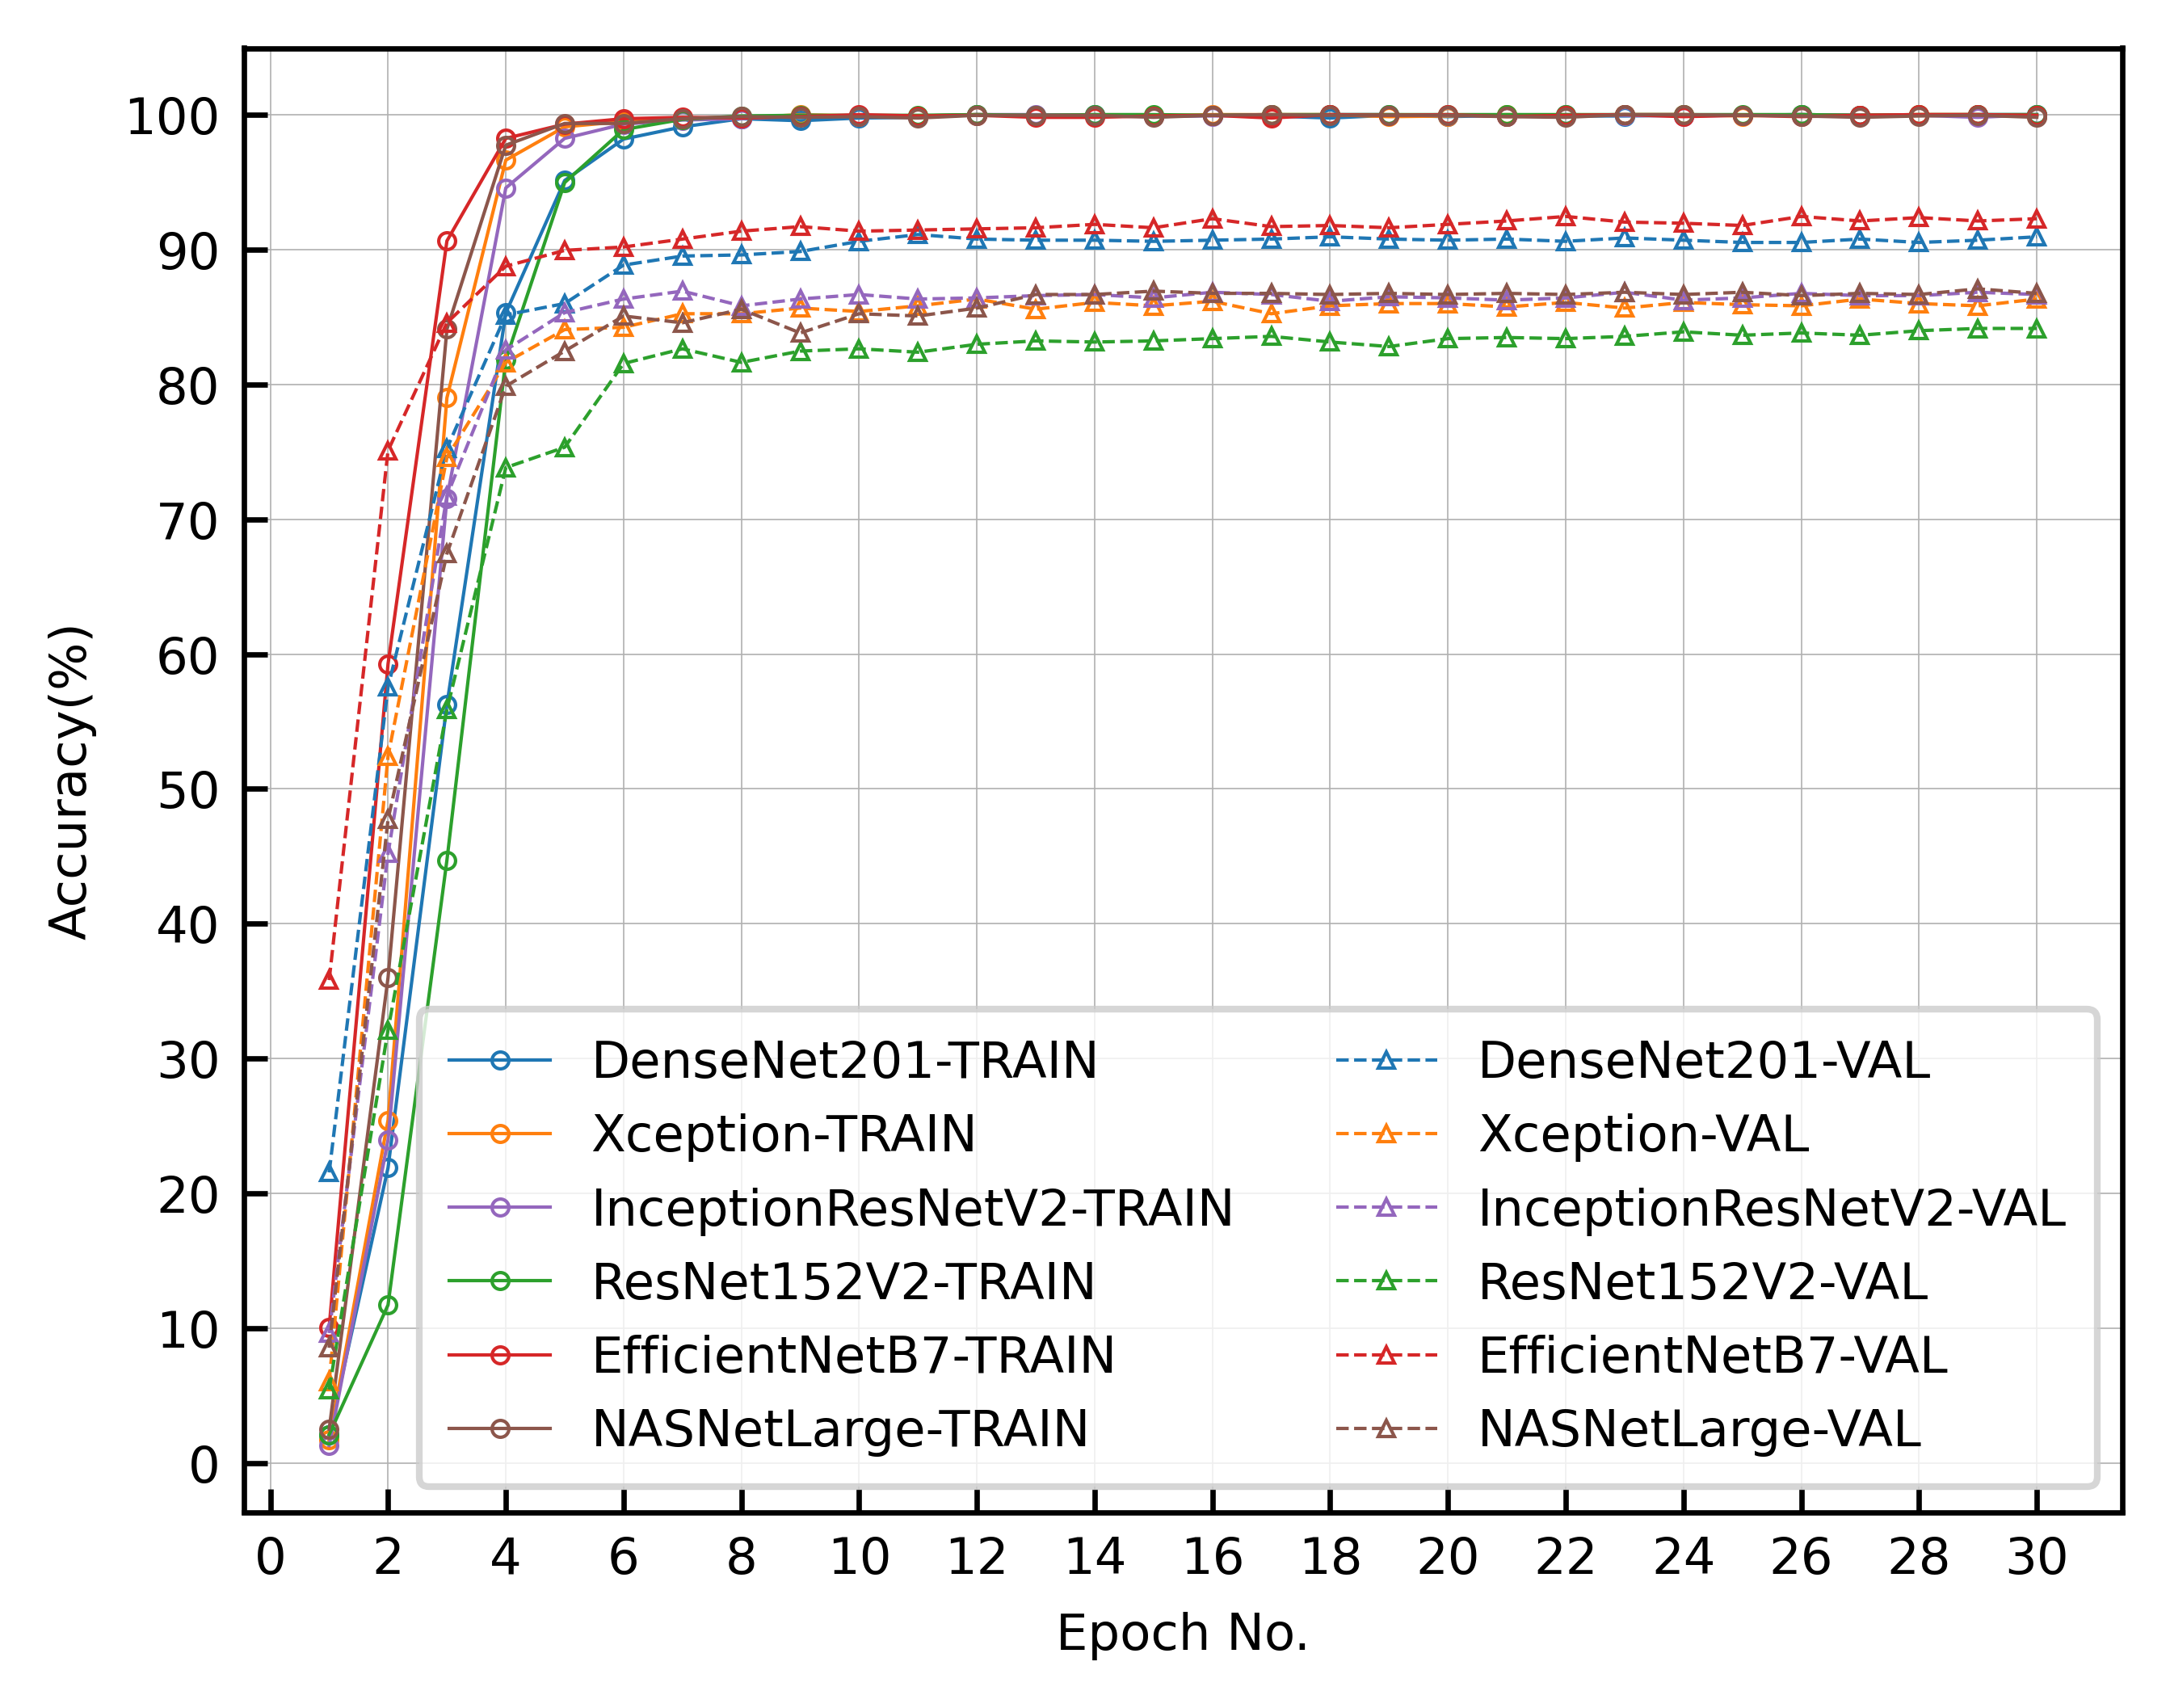

In [14]:
print("[INFO] ACCURACY CURVES FOR TEACHERS")
plot_acc(MODEL_FILES[:-1])

**Plot Loss Curves**

[INFO] LOSS CURVES FOR TEACHERS


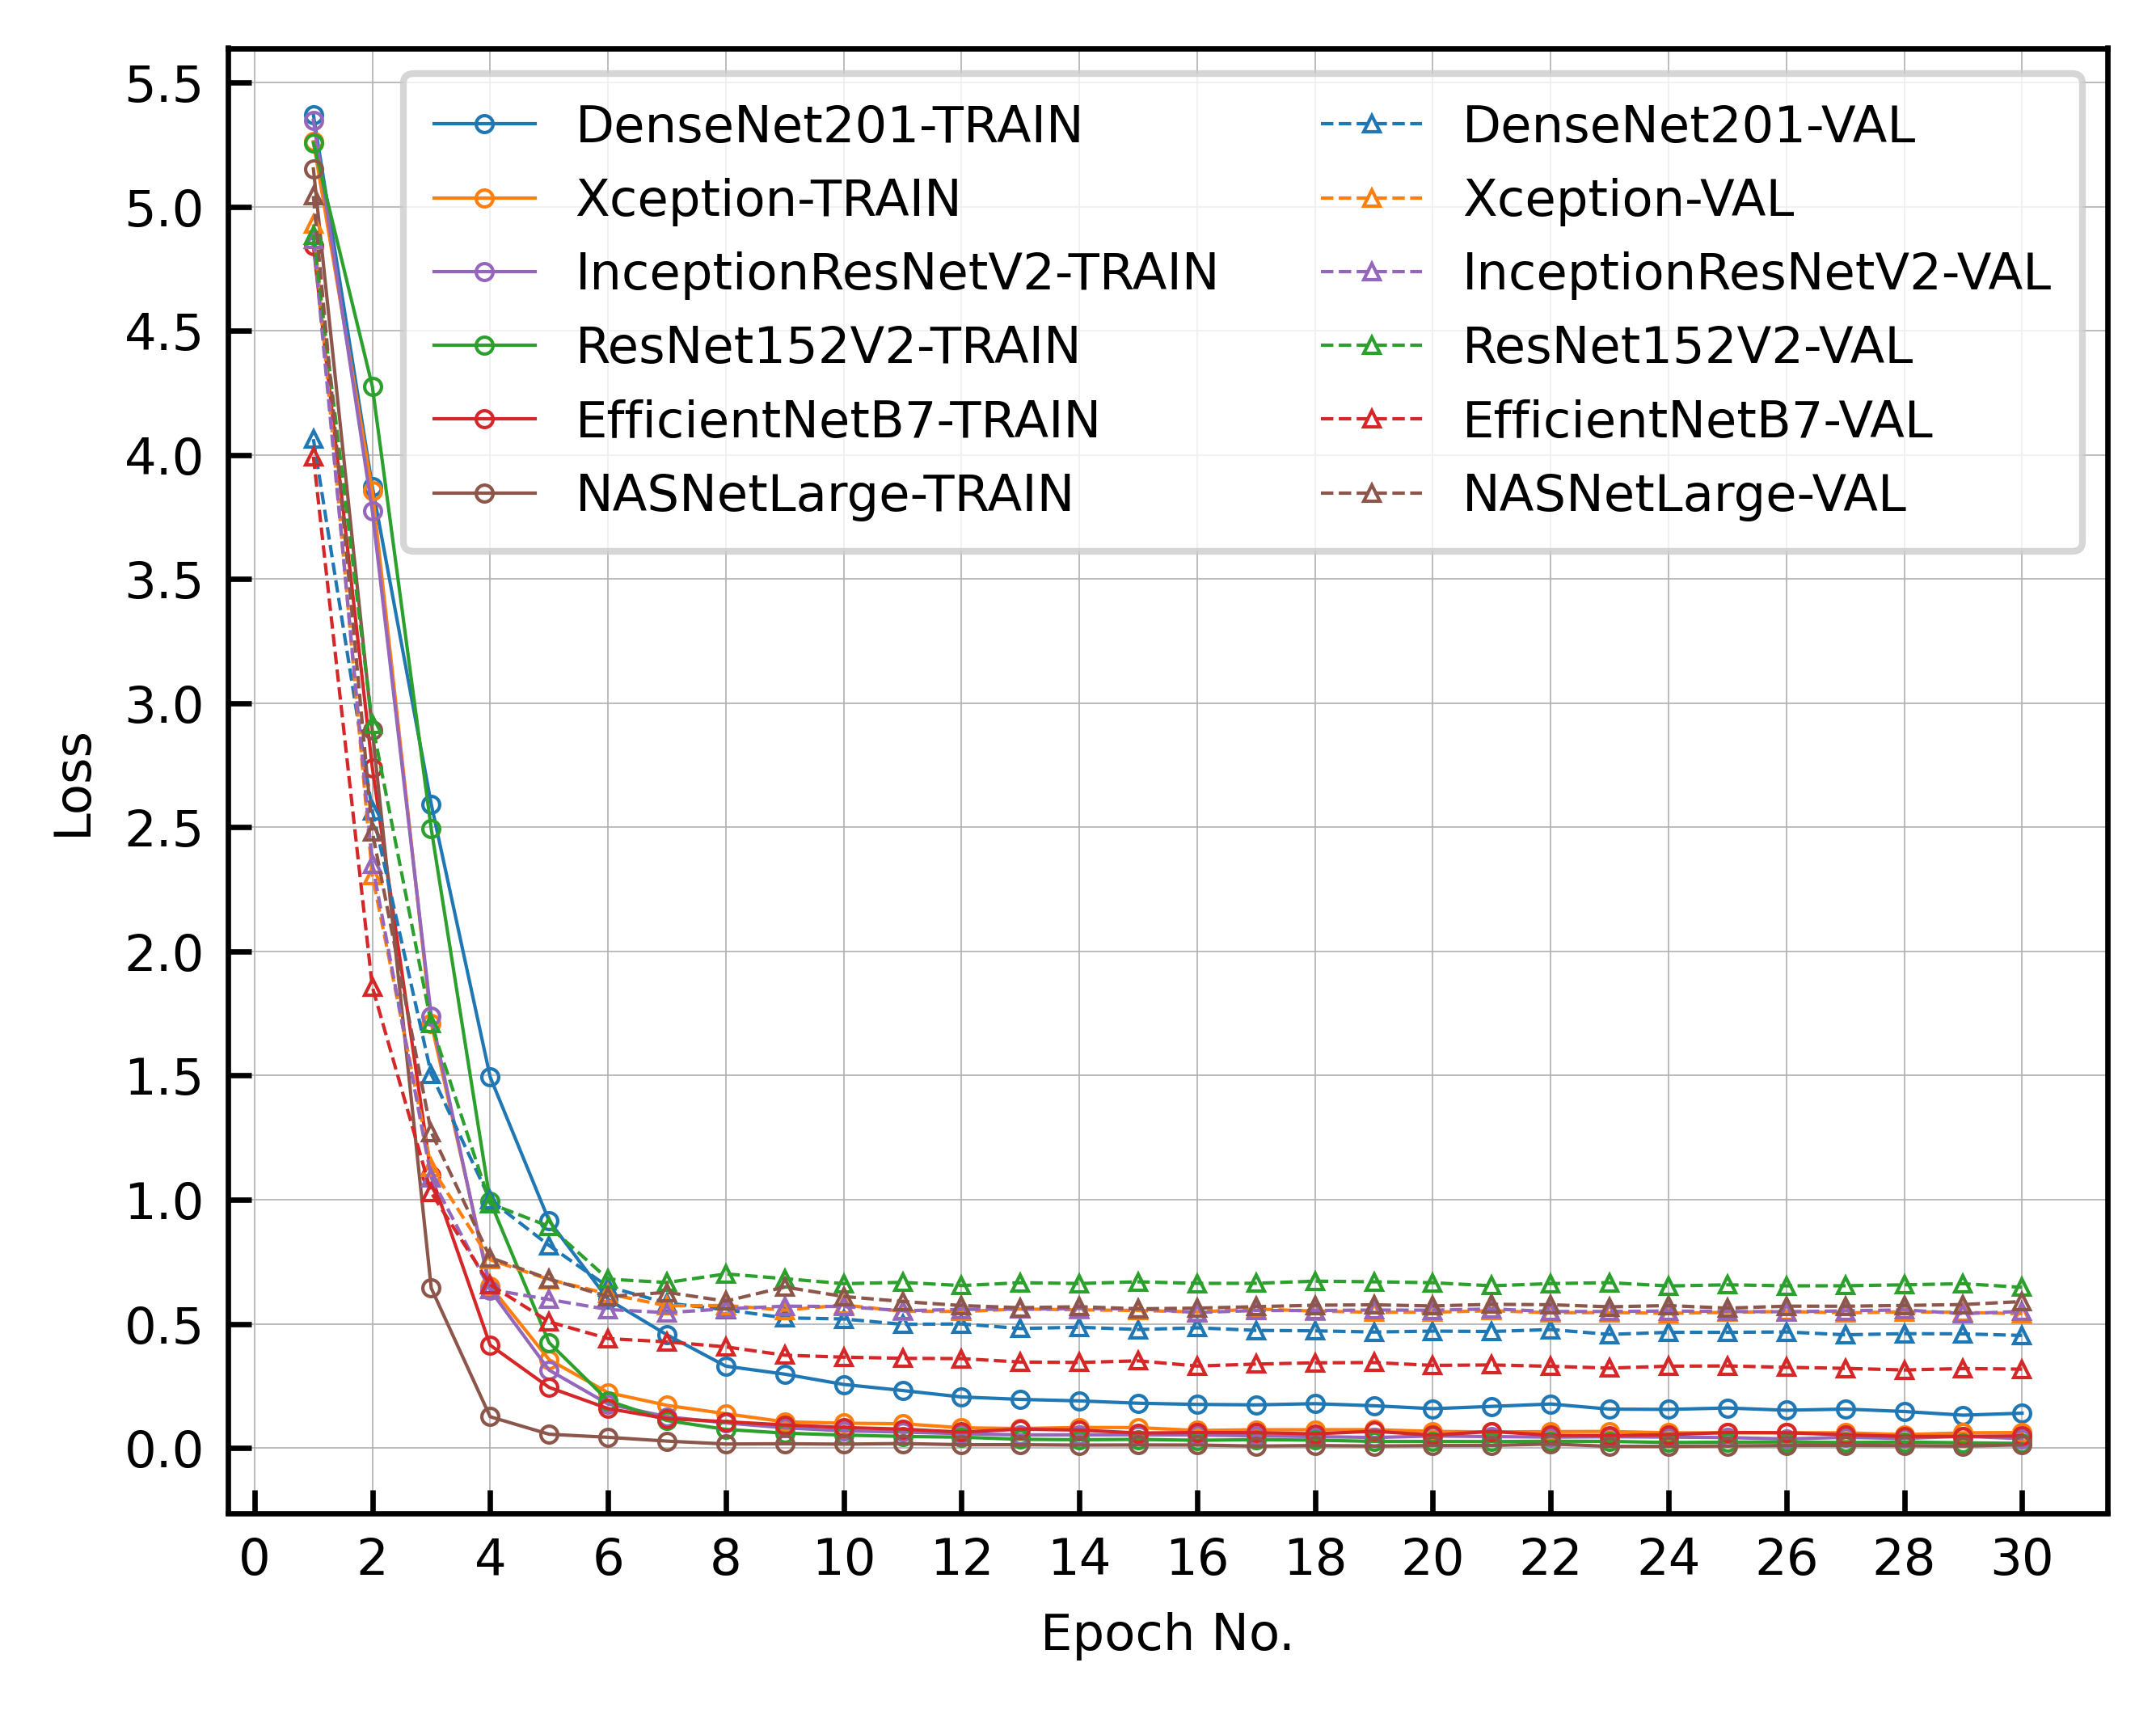

In [15]:
print("[INFO] LOSS CURVES FOR TEACHERS")
plot_loss(MODEL_FILES[:-1])

**Plot ROC Curves**

[INFO] ROC CURVES FOR TEACHERS ON VALIDATION SET


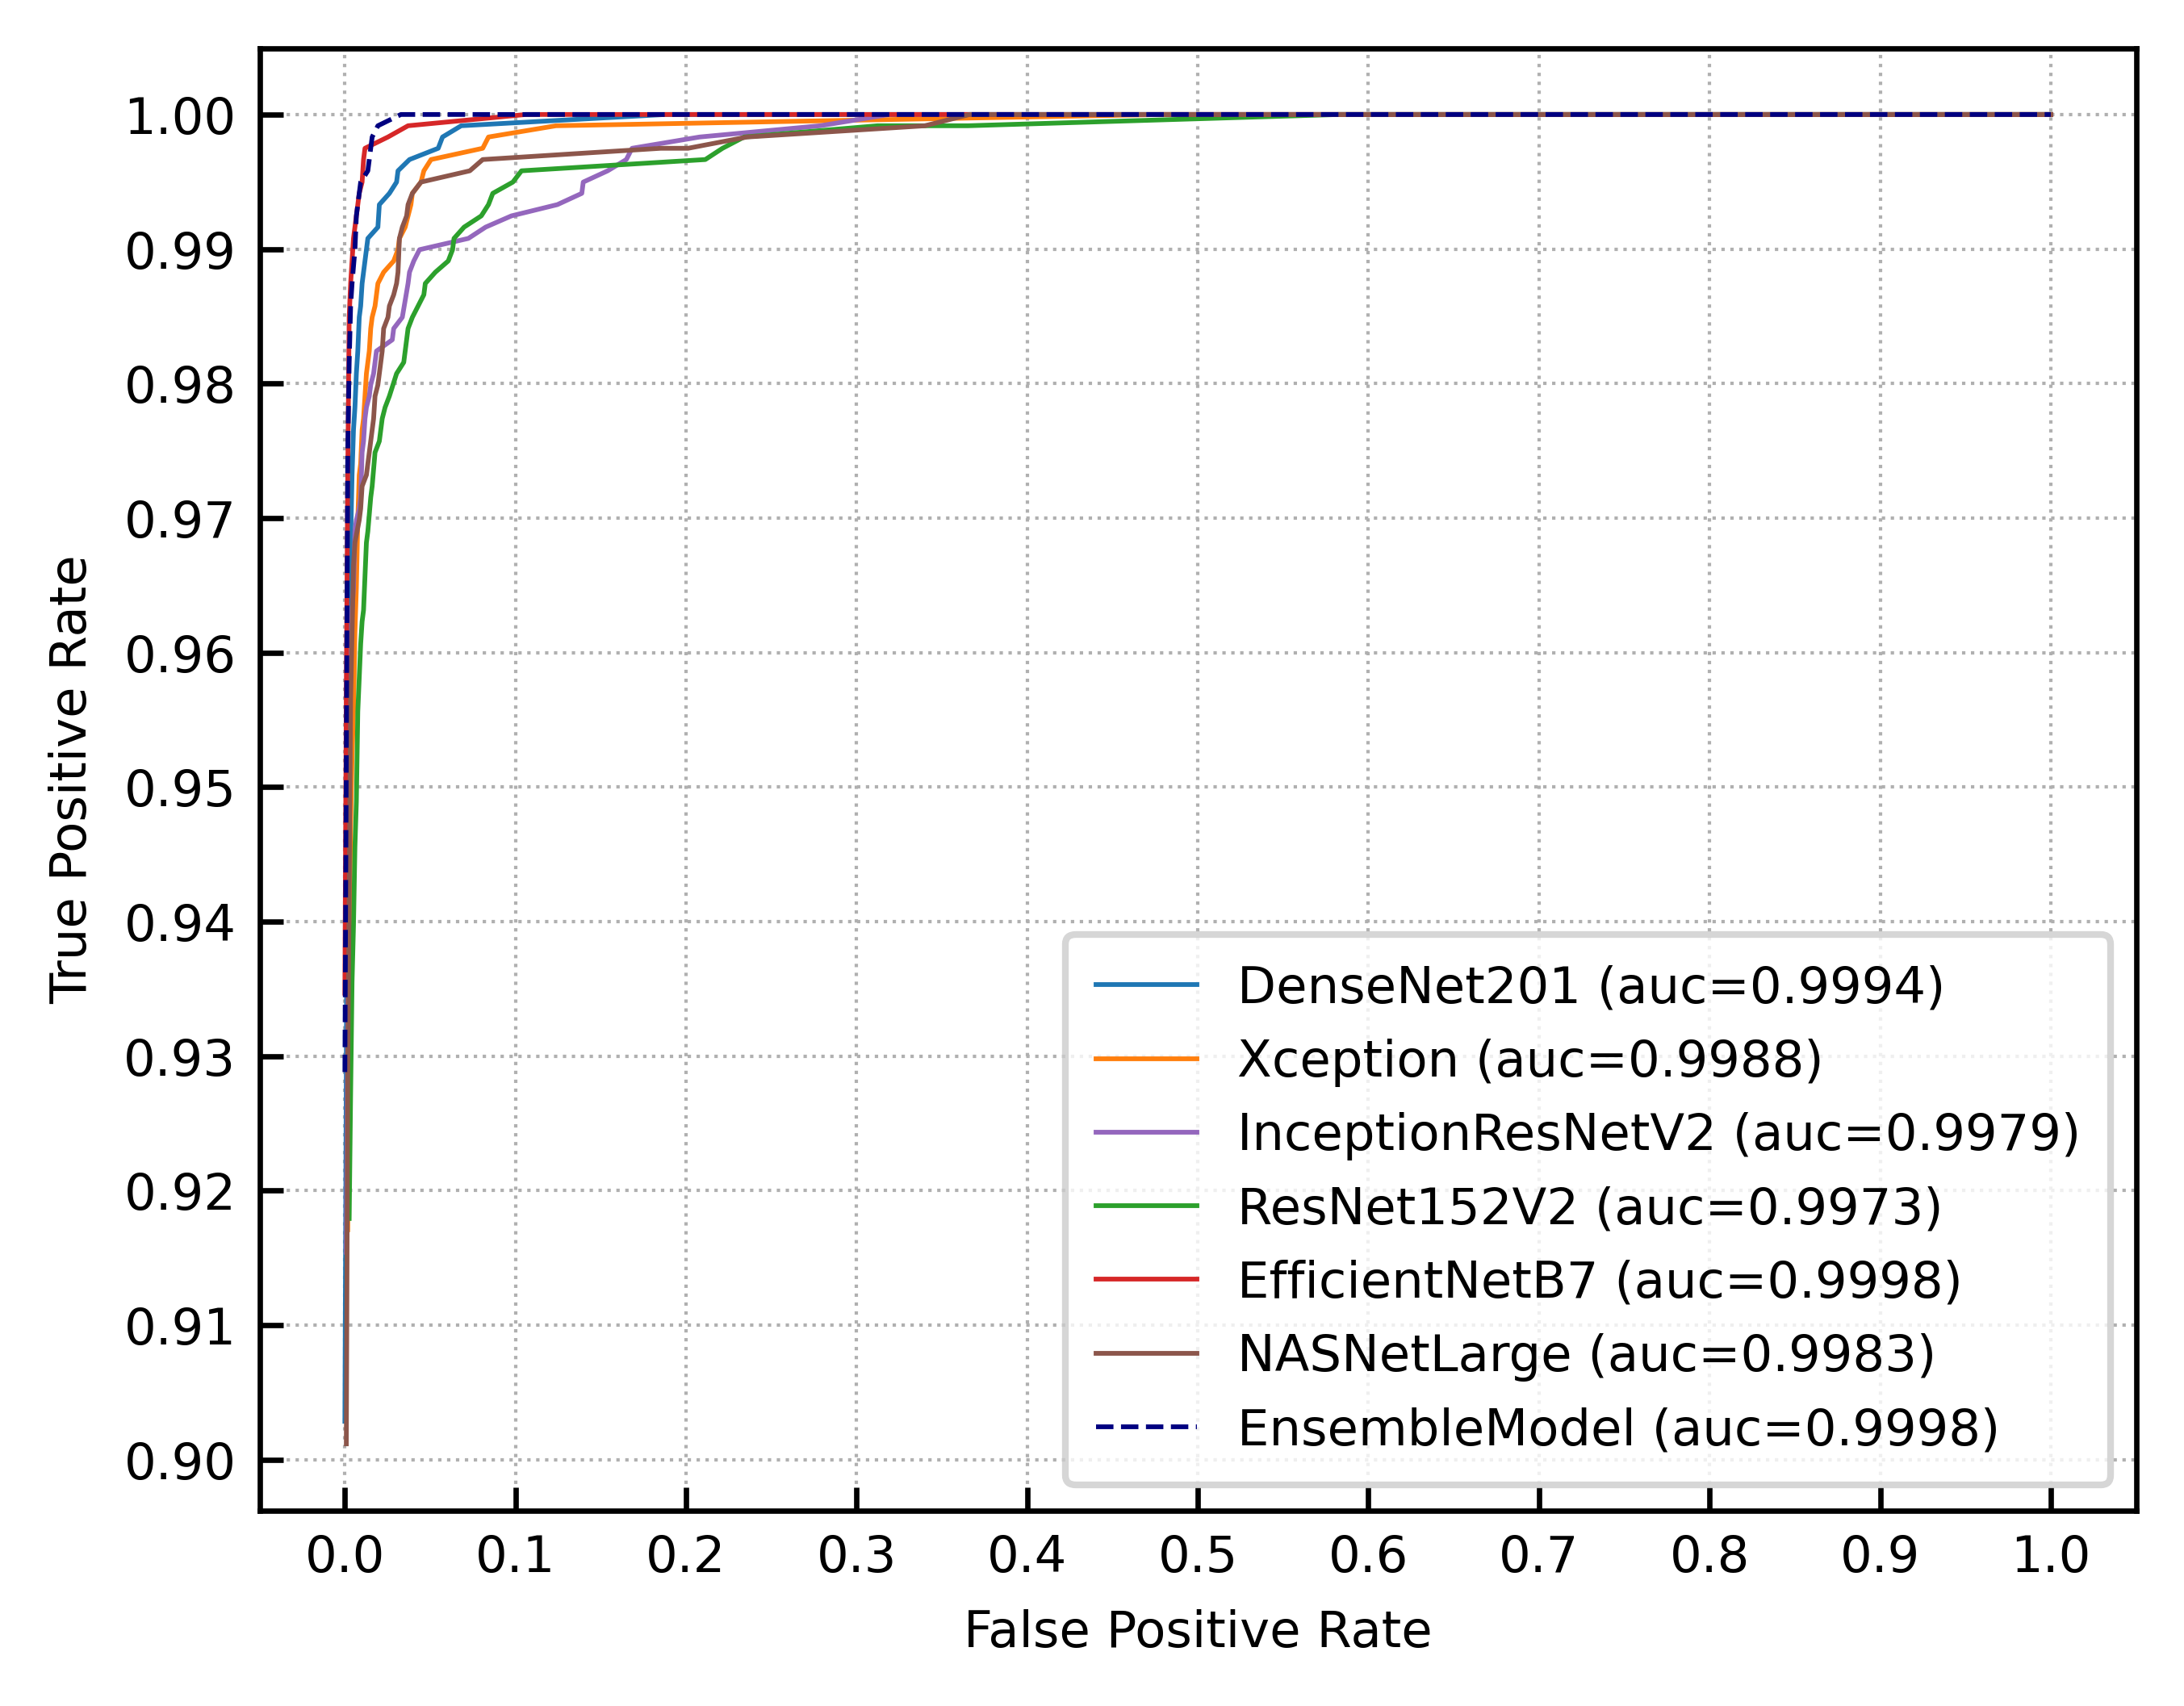

In [16]:
#On validation Set
print("[INFO] ROC CURVES FOR TEACHERS ON VALIDATION SET")
plot_roc(MODEL_FILES)

[INFO] ROC CURVES FOR TEACHERS ON TEST SET


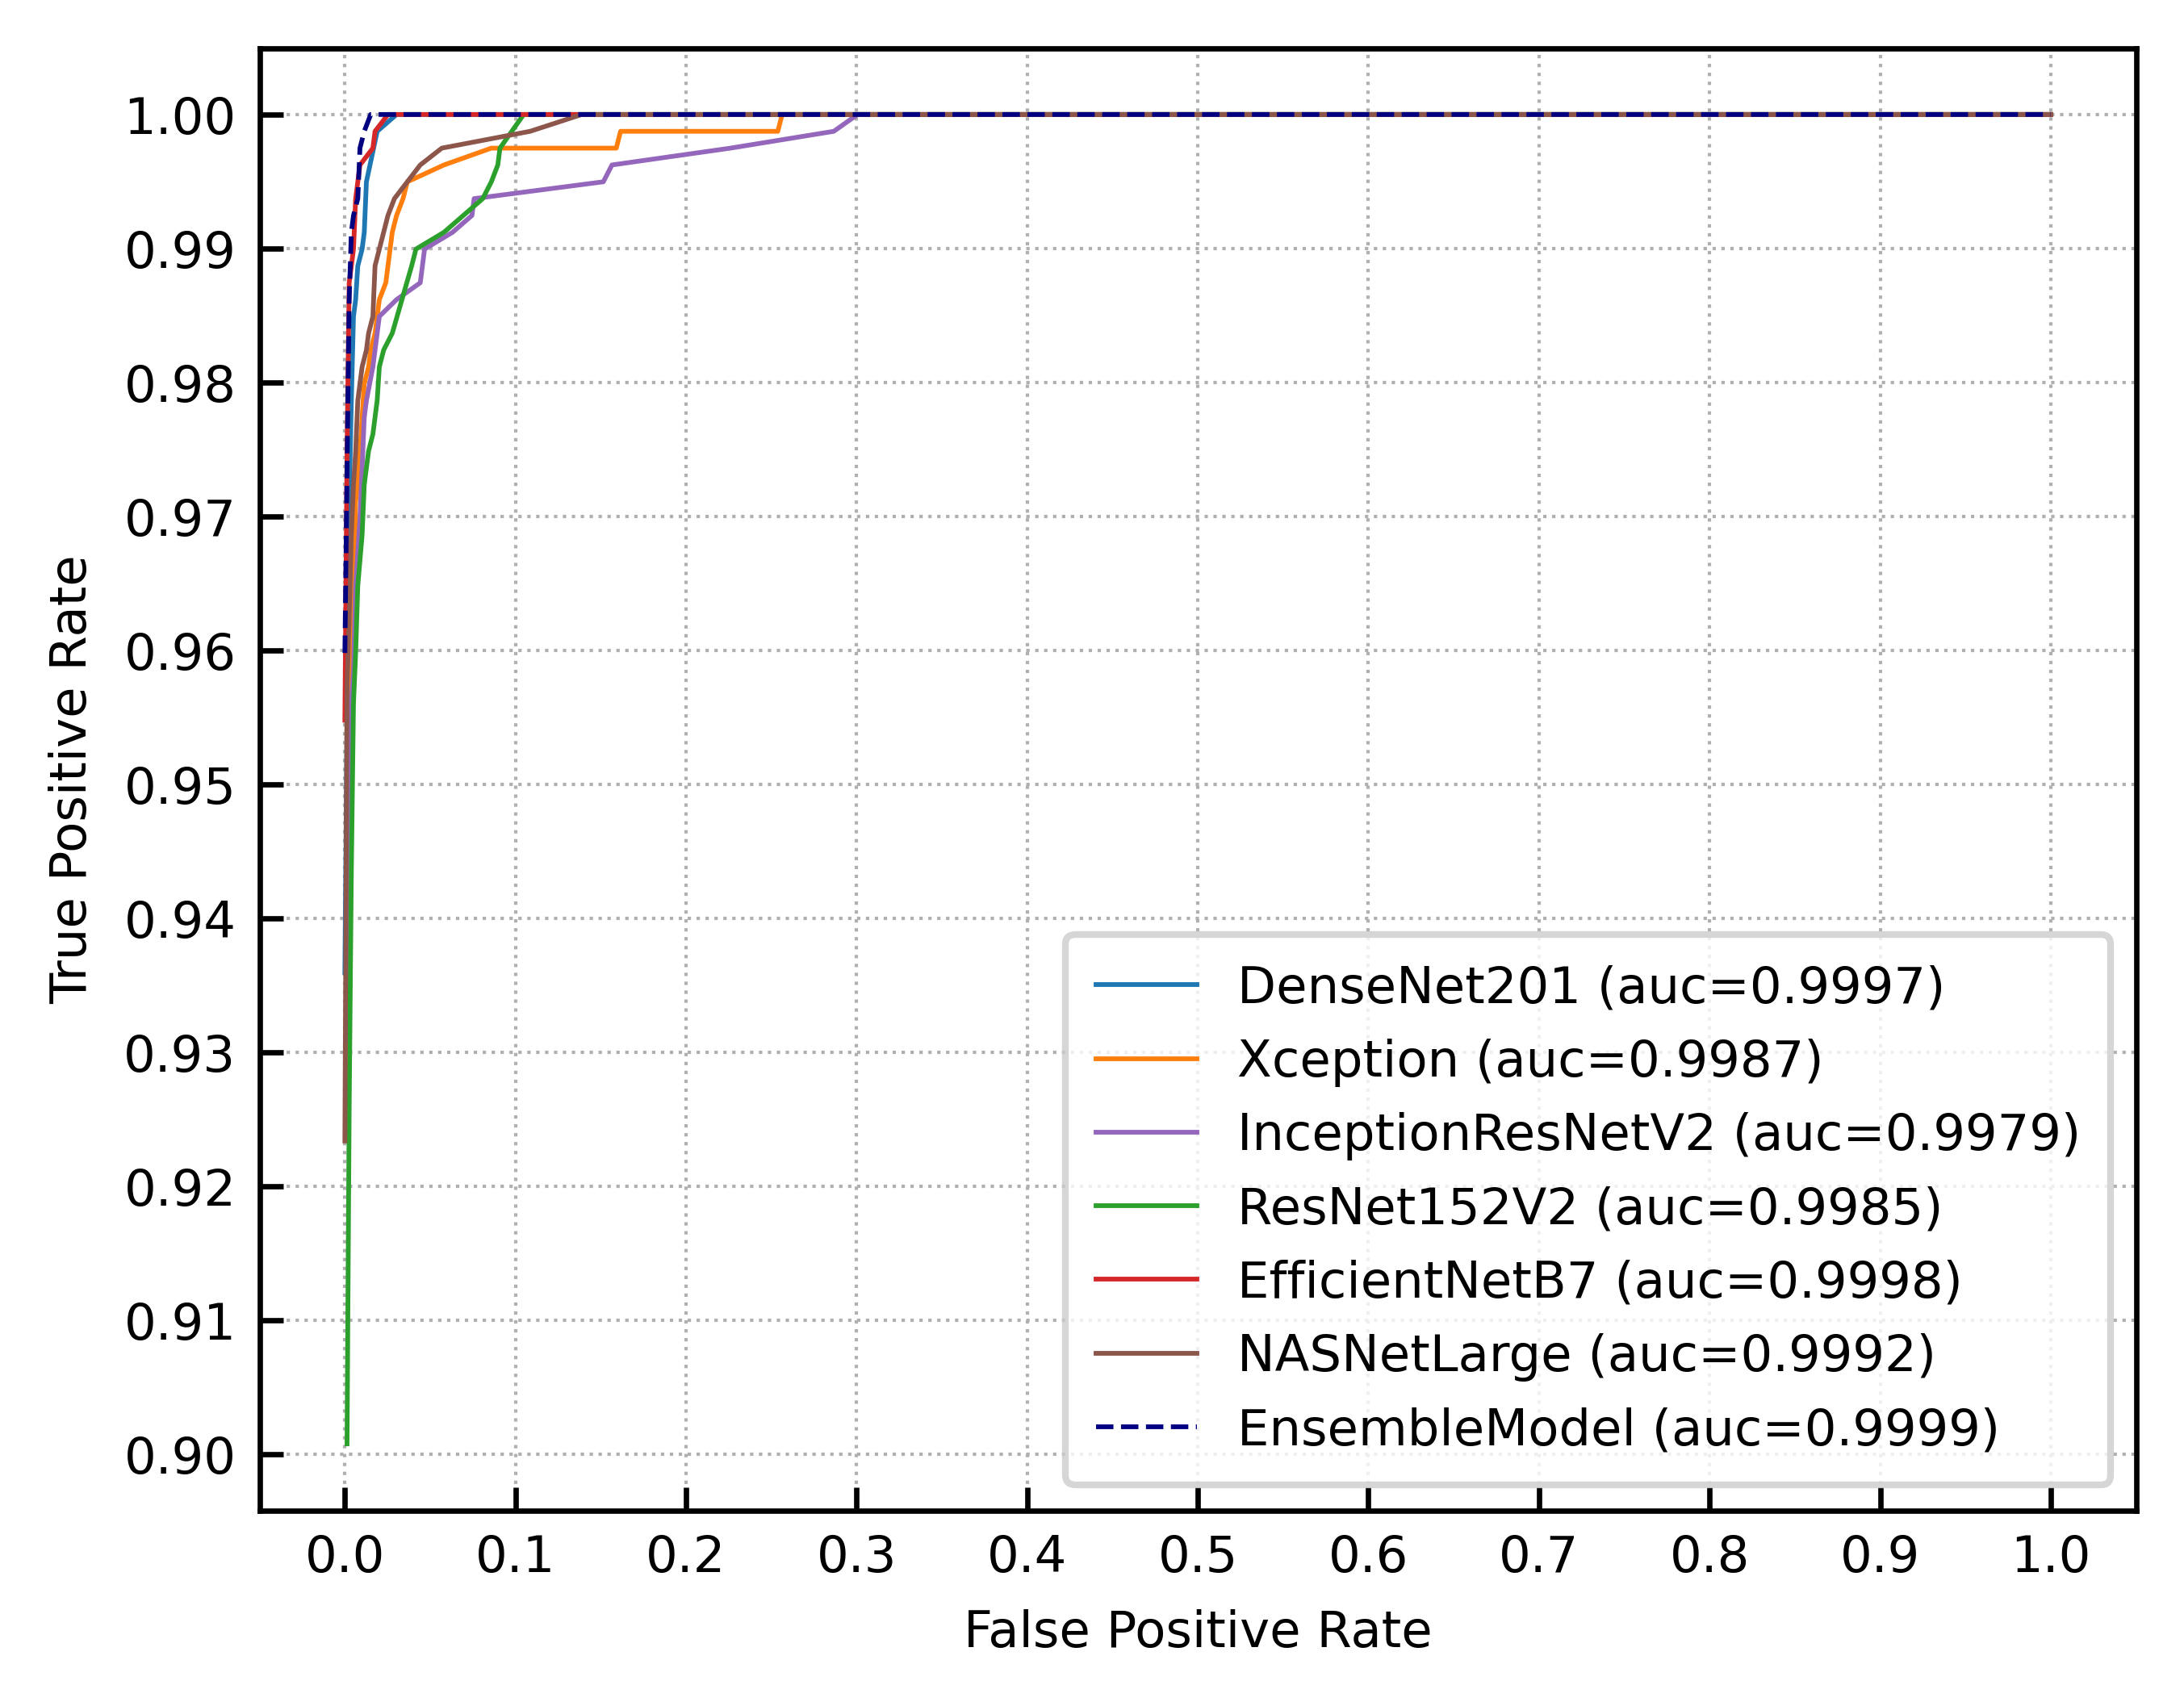

In [17]:
#On testing Set
print("[INFO] ROC CURVES FOR TEACHERS ON TEST SET")
plot_roc(MODEL_FILES, mode='TEST')

**Plot PR Curves**

[INFO] PR CURVES FOR TEACHERS ON VALIDATION SET


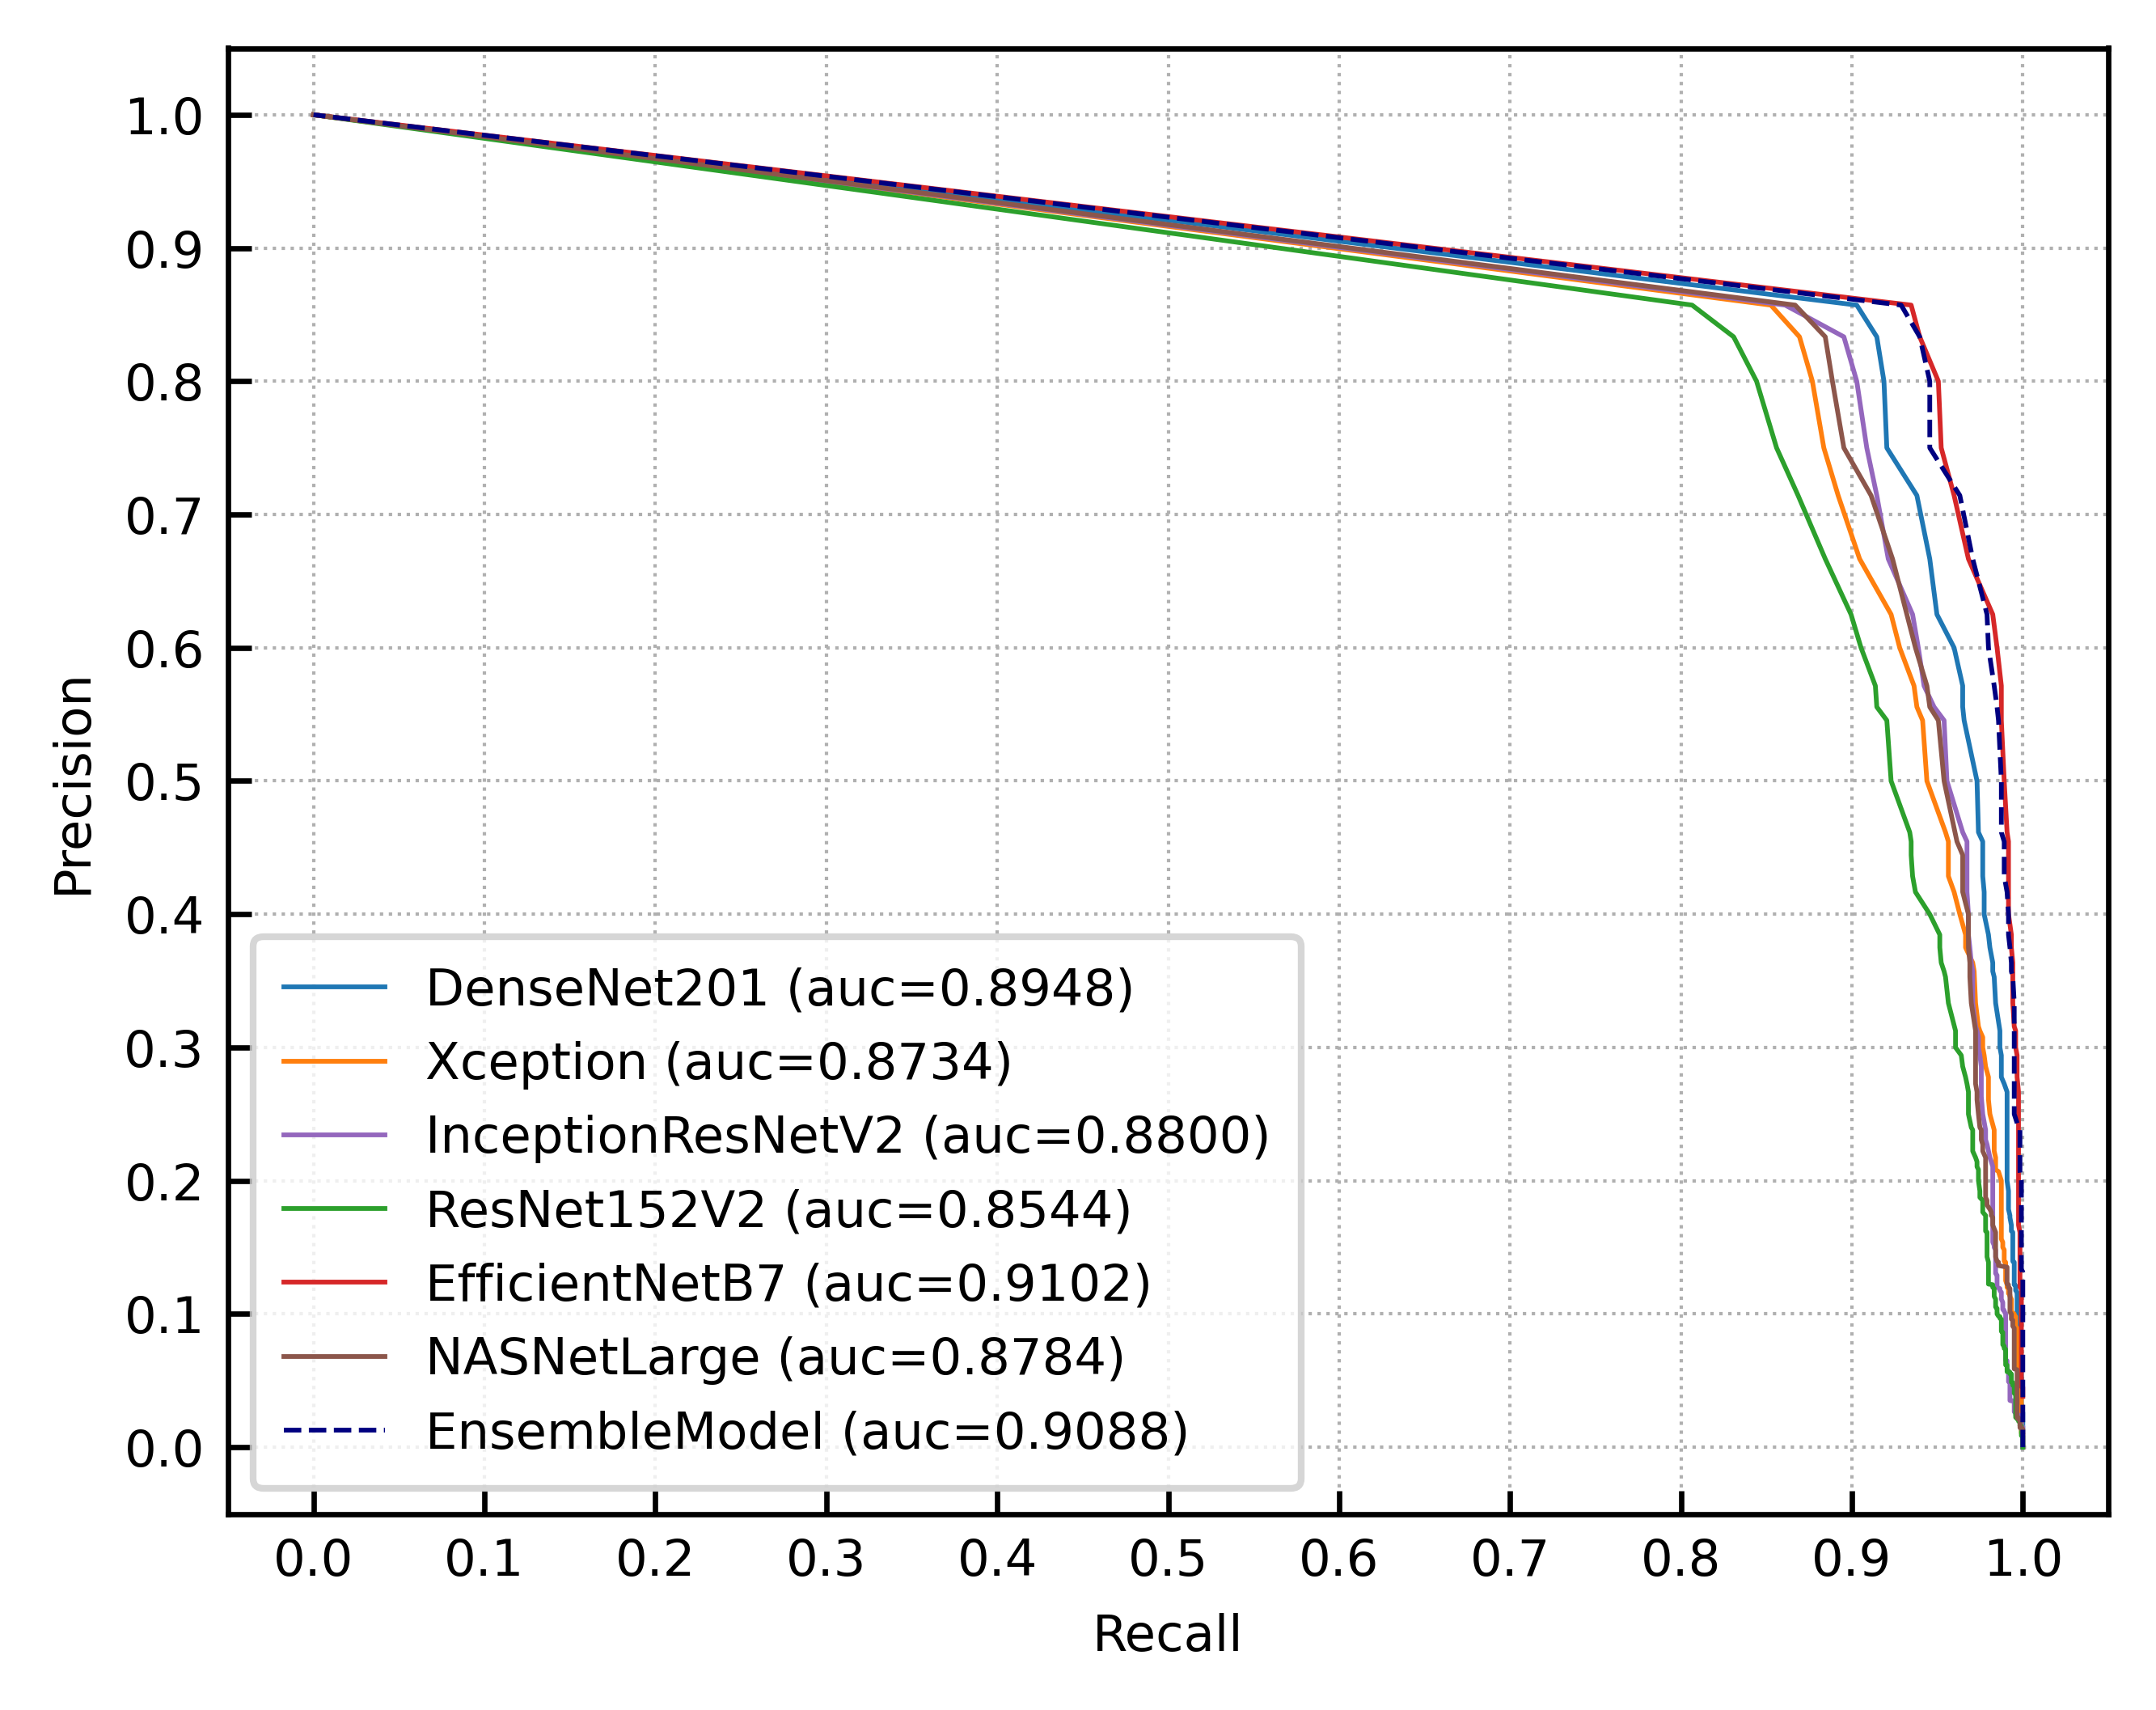

In [18]:
#On validation Set
print("[INFO] PR CURVES FOR TEACHERS ON VALIDATION SET")
plot_pr(MODEL_FILES)

[INFO] PR CURVES FOR TEACHERS ON TEST SET


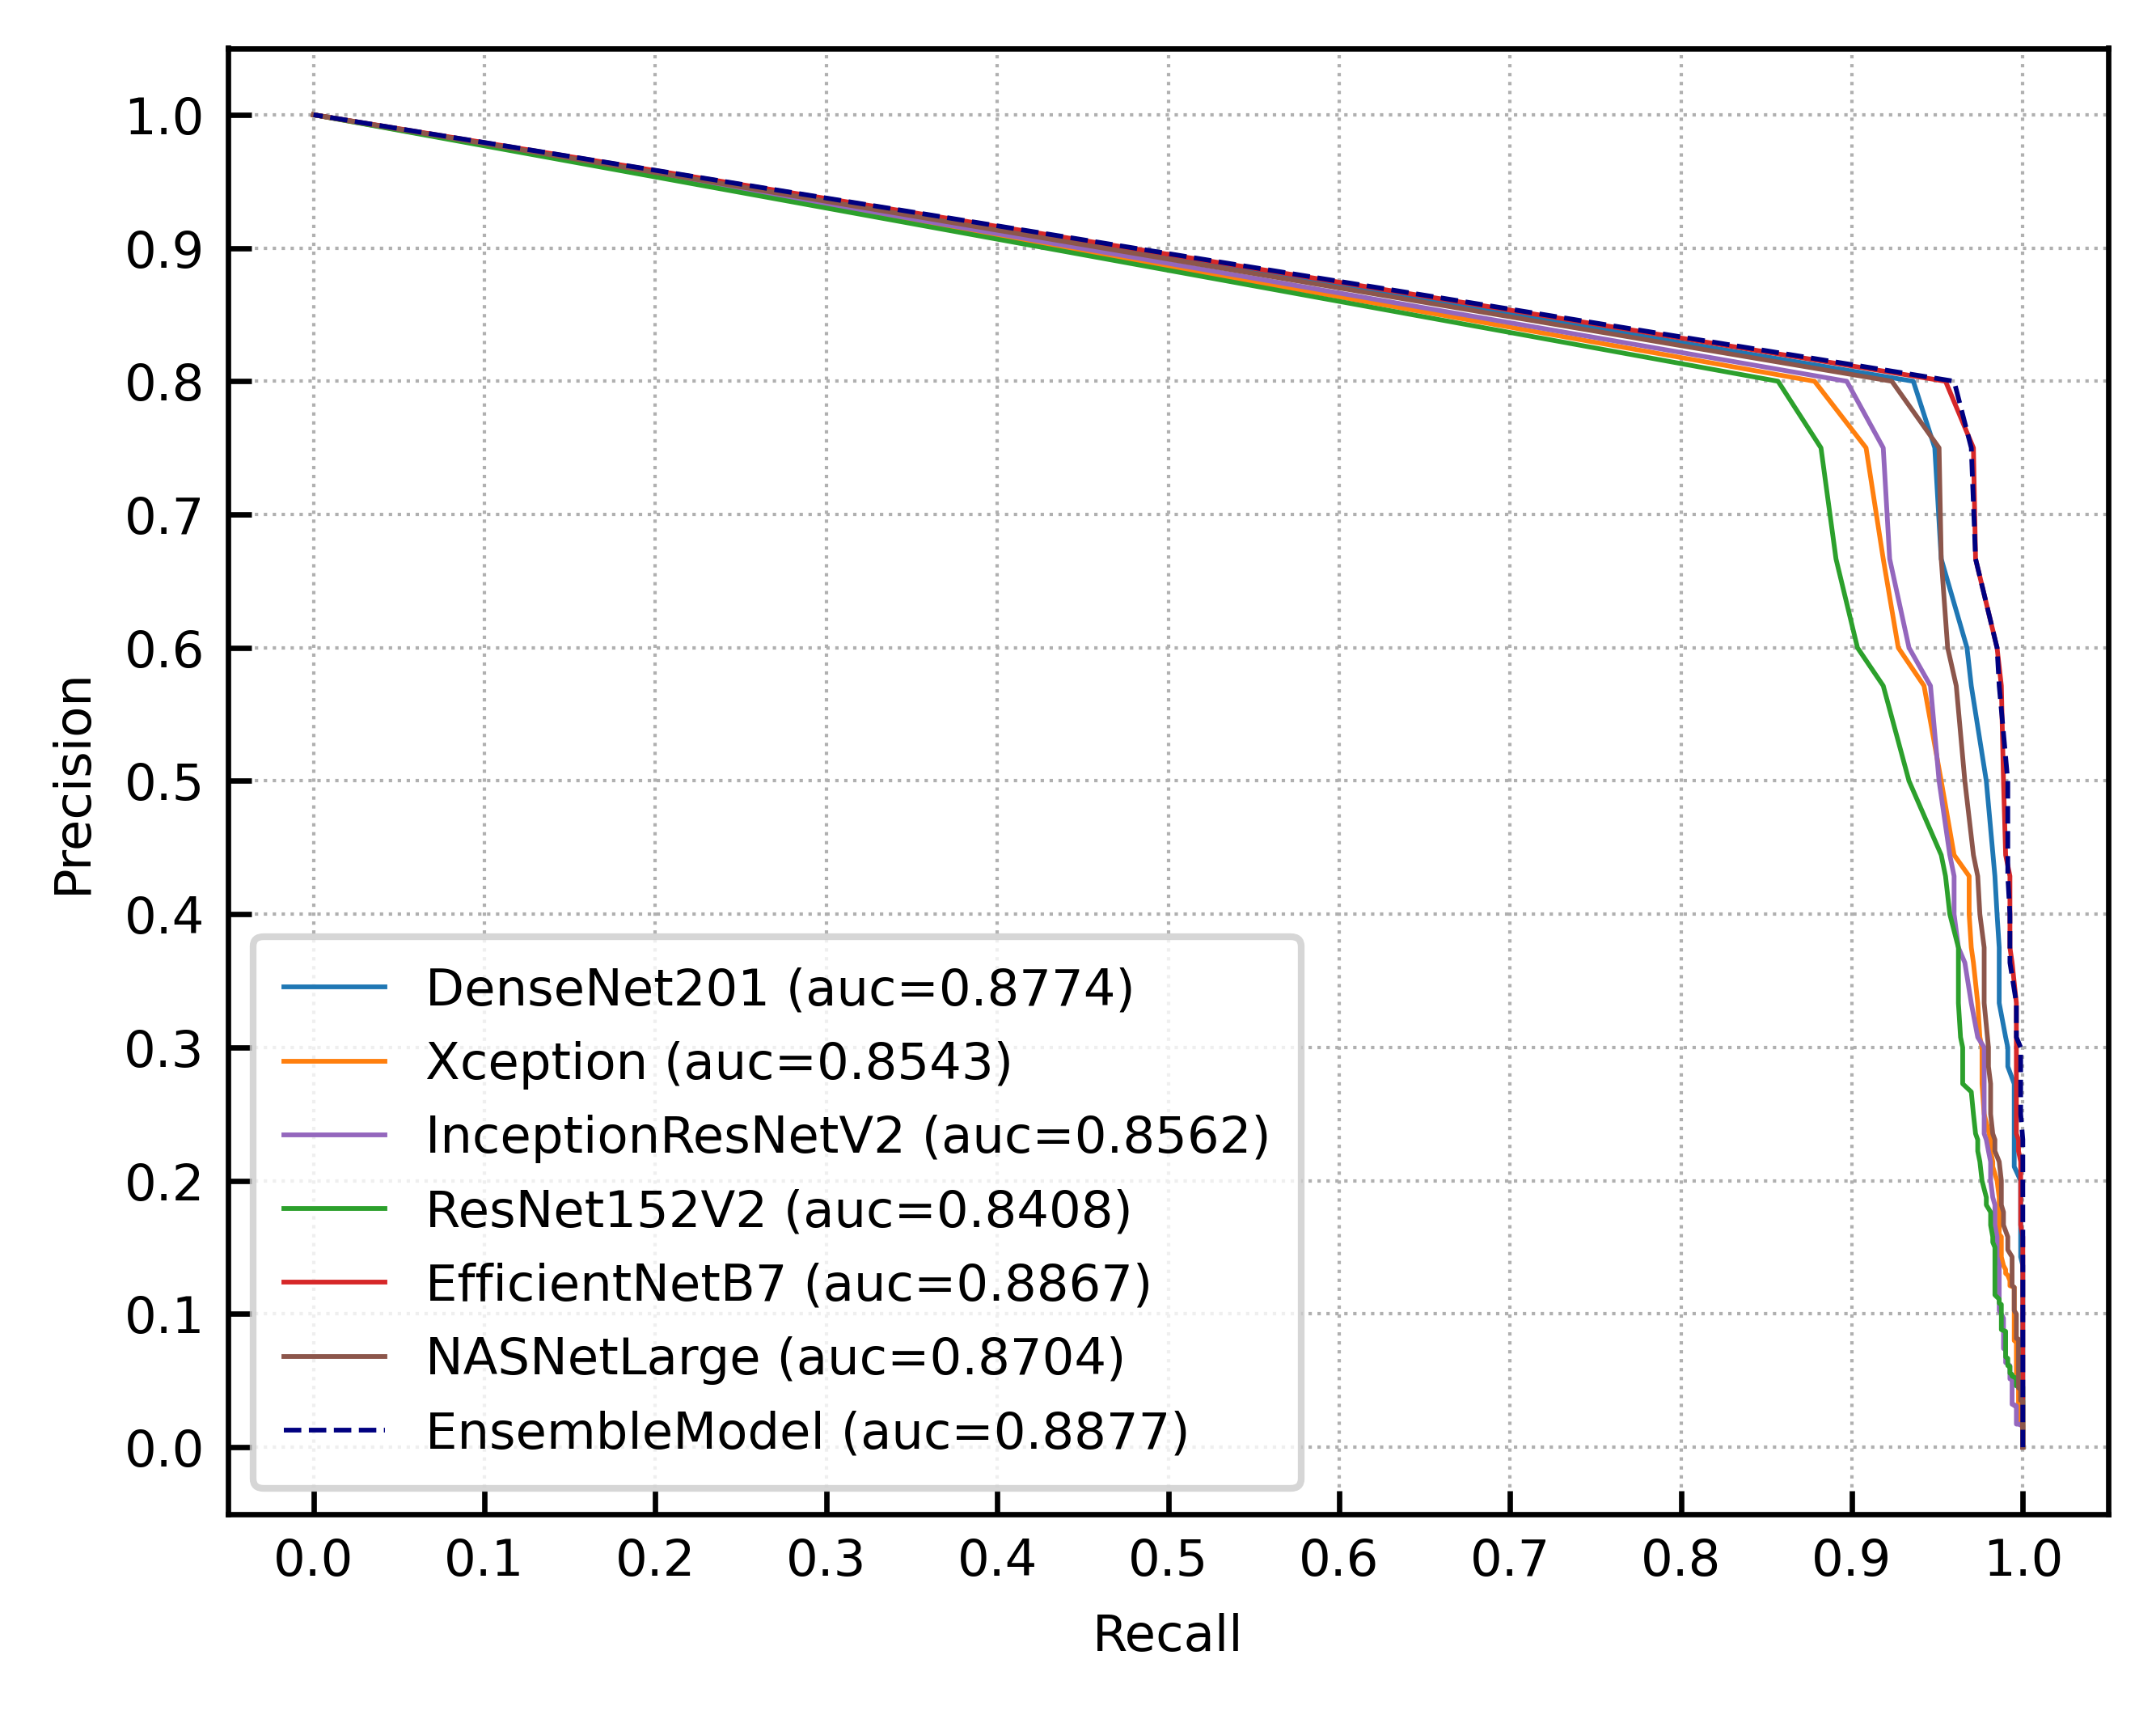

In [19]:
#On testing Set
print("[INFO] PR CURVES FOR TEACHERS ON TEST SET")
plot_pr(MODEL_FILES, mode='TEST')

**Confusion Matrix**

In [20]:
#On validation set
print("[INFO] CONFUSION MATRIX HEATMAP ON VALIDATION SET")
for i,file in enumerate(MODEL_FILES):
    print(str(i+1) + ': ' + file)
    plot_confusion(file)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
#On testing set
print("[INFO] CONFUSION MATRIX HEATMAP ON TEST SET")
for i,file in enumerate(MODEL_FILES):
    print(str(i+1) + ': ' + file)
    plot_confusion(file, mode='TEST')

Output hidden; open in https://colab.research.google.com to view.